Importing relevant packages

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(1334) 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from keras.backend import sigmoid
import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization, Bidirectional, LeakyReLU

Loading train,test and rul csv files as dataframes to be processed

In [ ]:
train_1= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/train_FD001.txt" ,sep=" ",header=None)
train_1.drop(columns=[26,27],inplace=True)

In [ ]:
test_1= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/test_FD001.txt",sep=" ",header=None)
test_1.drop(columns=[26,27],inplace=True)

In [ ]:
rul_1= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/RUL_FD001.txt",sep=" ",header=None)
rul_1.drop(columns=[1],inplace=True)

In [ ]:
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_1.columns = columns
test_1.columns = columns

Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values

In [ ]:
train_1.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Investigate and remove columns/features that have constant standard deviation values as they do not carry information about the state of the unit

In [ ]:
description = train_1.describe()
description.loc['std']

id          2.922763e+01
cycle       6.888099e+01
setting1    2.187313e-03
setting2    2.930621e-04
setting3    0.000000e+00
s1          6.537152e-11
s2          5.000533e-01
s3          6.131150e+00
s4          9.000605e+00
s5          3.394700e-12
s6          1.388985e-03
s7          8.850923e-01
s8          7.098548e-02
s9          2.208288e+01
s10         4.660829e-13
s11         2.670874e-01
s12         7.375534e-01
s13         7.191892e-02
s14         1.907618e+01
s15         3.750504e-02
s16         1.556432e-14
s17         1.548763e+00
s18         0.000000e+00
s19         0.000000e+00
s20         1.807464e-01
s21         1.082509e-01
Name: std, dtype: float64

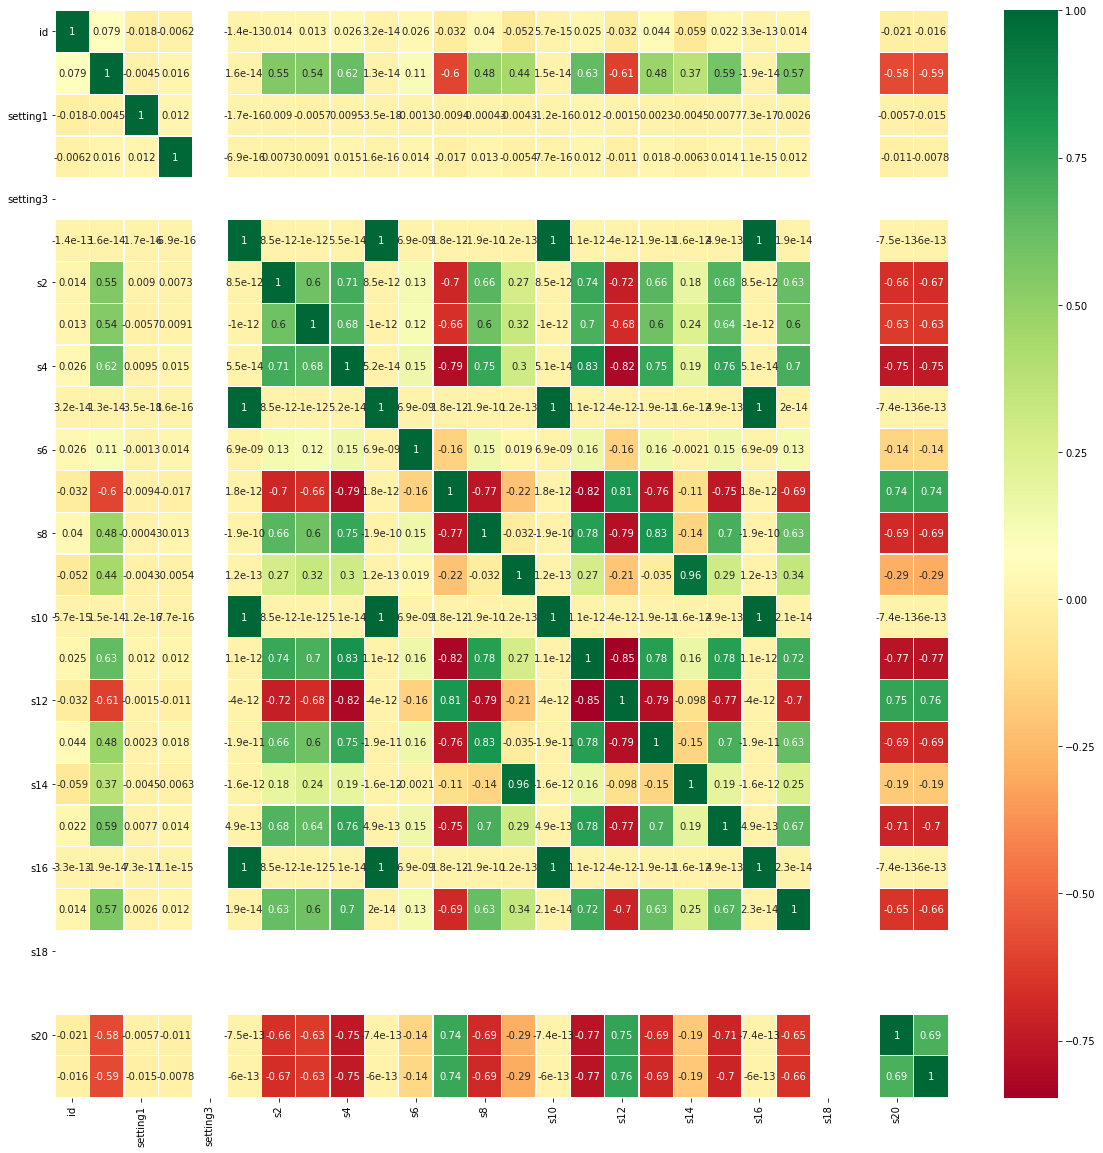

In [ ]:
sns.heatmap(train_1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
#delete columns with constant values that do not carry information about the state of the unit
train_1.drop(columns=['s6','s16','s19','s18','s17','s10','s5','s1','setting3','setting1','setting2'],inplace=True)

In [ ]:
description = train_1.describe()
description.loc['std']

id       29.227633
cycle    68.880990
s2        0.500053
s3        6.131150
s4        9.000605
s7        0.885092
s8        0.070985
s9       22.082880
s11       0.267087
s12       0.737553
s13       0.071919
s14      19.076176
s15       0.037505
s20       0.180746
s21       0.108251
Name: std, dtype: float64

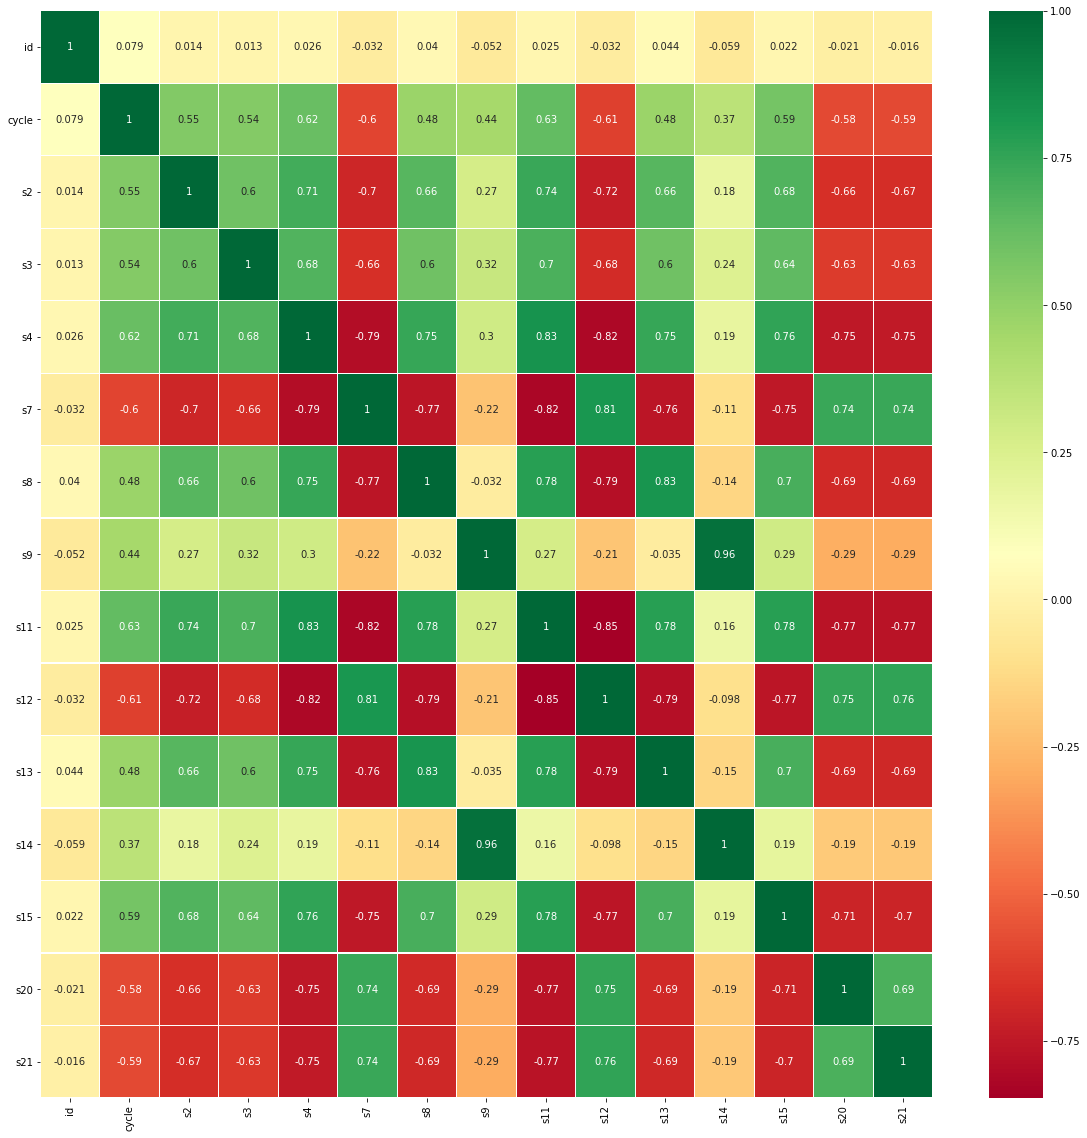

In [ ]:
sns.heatmap(train_1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('id')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['id','max']
    df = df.merge(fd_RUL, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df['RUL'] = df['RUL'].clip(upper=180)                     #clipping
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

train_1 = prepare_train_data(train_1)

Display mutual correlations of signs using heat map including the newly created RUL column

In [ ]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

Preprocessing for LSTM

In [ ]:
# MinMax normalization (from 0 to 1) train set
train_1['cycle_norm'] = train_1['cycle']
cols_normalize = train_1.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_1 = pd.DataFrame(min_max_scaler.fit_transform(train_1[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_1.index)
join_df = train_1[train_1.columns.difference(cols_normalize)].join(norm_train_1)
train_1 = join_df.reindex(columns = train_1.columns)

# MinMax normalization (from 0 to 1) test set
test_1['cycle_norm'] = test_1['cycle']
norm_test_1 = pd.DataFrame(min_max_scaler.transform(test_1[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_1.index)
test_join_df = test_1[test_1.columns.difference(cols_normalize)].join(norm_test_1)
test_1 = test_join_df.reindex(columns = test_1.columns)
test_1 = test_1.reset_index(drop=True)
print(test_1.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_1.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul_1.columns = ['more']
rul_1['id'] = rul_1.index + 1
rul_1['max'] = rul['max'] + rul_1['more']
rul_1.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_1 = test_1.merge(rul_1, on=['id'], how='left')
test_1['RUL'] = test_1['max'] - test_1['cycle']
test_1['RUL'] = test_1['RUL'].clip(upper=180)                #clipping
test_1.drop('max', axis=1, inplace=True)

   id  cycle  setting1  setting2  ...    s19       s20       s21  cycle_norm
0   1      1    0.0023    0.0003  ...  100.0  0.558140  0.661834     0.00000
1   1      2   -0.0027   -0.0003  ...  100.0  0.682171  0.686827     0.00277
2   1      3    0.0003    0.0001  ...  100.0  0.728682  0.721348     0.00554
3   1      4    0.0042    0.0000  ...  100.0  0.666667  0.662110     0.00831
4   1      5    0.0014    0.0000  ...  100.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


Feature Selection

In [ ]:
train_1.columns

Index(['id', 'cycle', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
       's14', 's15', 's20', 's21', 'RUL', 'cycle_norm'],
      dtype='object')

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

train_features = train_1[['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's20', 's21']]
train_labels = train_1['RUL']
selector = SelectKBest(f_classif, k=10)
selected_features = selector.fit_transform(train_features, train_labels)

In [ ]:
selector.scores_

array([112.07549804,  98.92150142, 182.58640107, 154.50274727,
        84.56448028,  35.75945374, 207.61414023, 172.04898761,
        83.93648362,  20.96332254, 144.35602299, 129.67747722,
       132.84756919])

In [ ]:
#Finding 20th percentile
lower = np.percentile(selector.scores_, 20)
lower

84.18768228459487

In [ ]:
c = selector.scores_ >= lower
c.tolist()
index_list = [i for i, x in enumerate(c) if x]
index_list

[0, 1, 2, 3, 4, 6, 7, 10, 11, 12]

In [ ]:
final_selected_features = []
for i in index_list:
  final_selected_features.append(train_features.columns[i])
  # print(train_features.columns[i])

Data Preparation for LSTM

In [ ]:
sequence_length = 50

In [ ]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_1[test_1['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s20','s21']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]


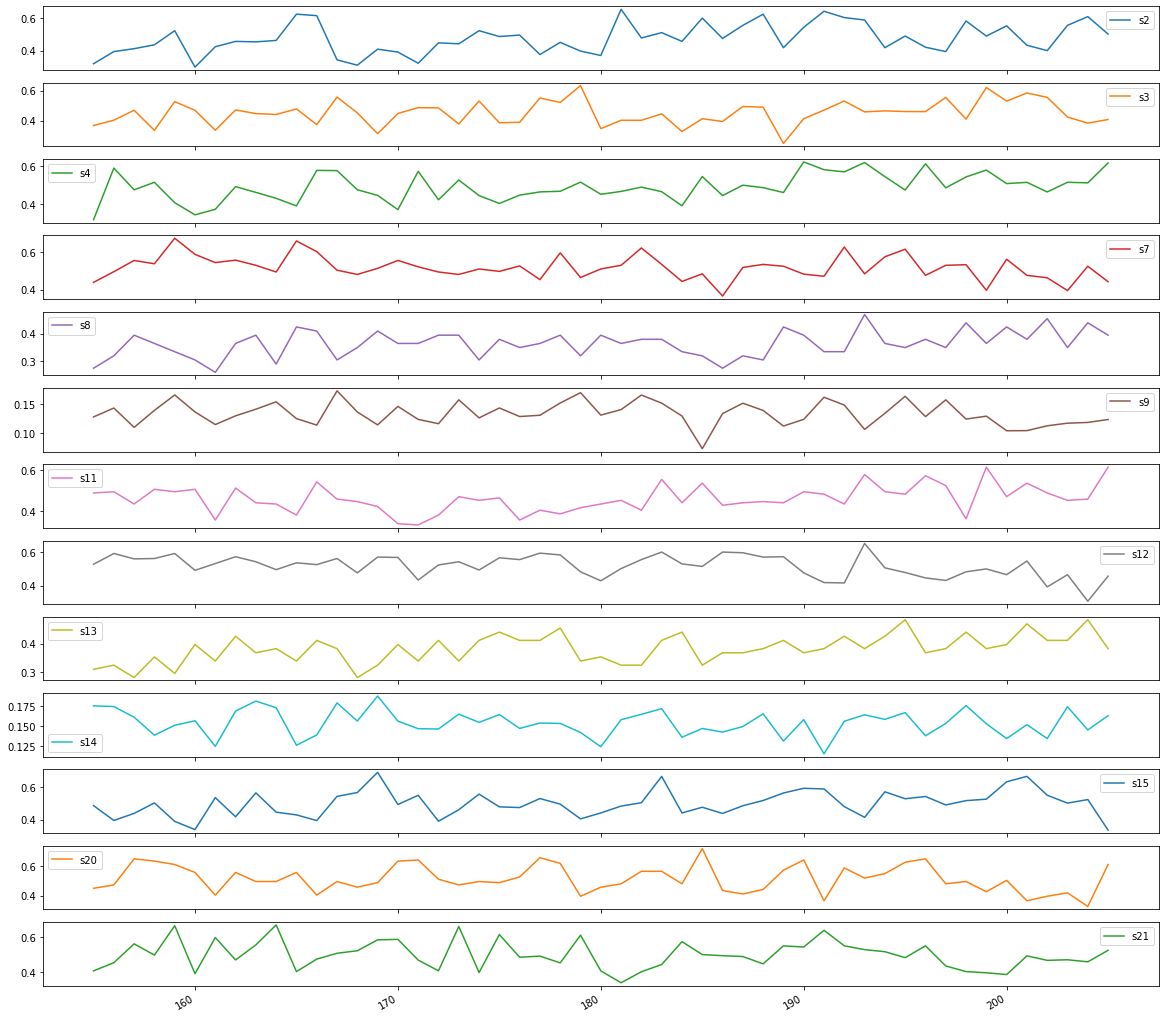

In [ ]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

In [ ]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
# pick the feature columns 
# sequence_cols = ['cycle_norm','s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s20','s21']
sequence_cols = final_selected_features
seq_gen = (list(gen_sequence(train_1[train_1['id']==id], sequence_length, sequence_cols)) 
           for id in train_1['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 10)

In [ ]:
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [ ]:
# generate labels
label_gen = [gen_labels(train_1[train_1['id']==id], sequence_length, ['RUL']) 
             for id in train_1['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [ ]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

LSTM, BASE MODEL


In [ ]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_model = Sequential()

lstm_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=50,
         return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=20,
          return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=20,
          return_sequences=False))
lstm_model.add(Dropout(0.3))

lstm_model.add(Dense(units=nb_out, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse',r2_keras])

lstm_model.summary()

# optimizer='rmsprop'

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 50)            12200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 17,901
Trainable params: 17,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#metric for regression
# tf.keras.metrics.RootMeanSquaredError()

In [ ]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_model = Sequential()

lstm_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=300,
         return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=150,
          return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=nb_out, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse',r2_keras])

lstm_model.summary()

# # optimizer='rmsprop'

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50, 300)           378000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 150)               270600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 151       
Total params: 648,751
Trainable params: 648,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# fit the network
fitting = lstm_model.fit(seq_array, label_array, epochs=300, batch_size=32, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min')])
fitting

Epoch 1/300
465/465 [==============================] - 24s 43ms/step - loss: 8168.2505 - mse: 8168.2505 - r2_keras: -2274559.4805 - val_loss: 6971.3892 - val_mse: 6971.3892 - val_r2_keras: -343633264640.0000
Epoch 2/300
465/465 [==============================] - 19s 42ms/step - loss: 6599.5442 - mse: 6599.5442 - r2_keras: -2027609.6069 - val_loss: 5809.5791 - val_mse: 5809.5791 - val_r2_keras: -304793812992.0000
Epoch 3/300
465/465 [==============================] - 21s 45ms/step - loss: 5644.7970 - mse: 5644.7970 - r2_keras: -58813.6754 - val_loss: 4840.5420 - val_mse: 4840.5420 - val_r2_keras: -268714377216.0000
Epoch 4/300
465/465 [==============================] - 20s 43ms/step - loss: 4697.5914 - mse: 4697.5914 - r2_keras: -52636.3264 - val_loss: 4052.3196 - val_mse: 4052.3196 - val_r2_keras: -235060903936.0000
Epoch 5/300
465/465 [==============================] - 20s 43ms/step - loss: 3993.8549 - mse: 3993.8549 - r2_keras: -51498.6439 - val_loss: 3451.3242 - val_mse: 3451.3242 -

In [ ]:
lstm_model.save('D1_lstm_model_rmsprop_50_20.h5')

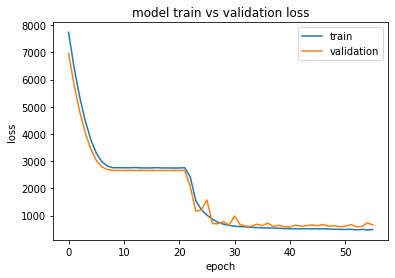

In [ ]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# training metrics
scores = lstm_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

79/79 [==============================] - 3s 36ms/step - loss: 426.4934 - mse: 426.4934 - r2_keras: 0.7822

MSE: 426.4934387207031

R^2: 0.7822497487068176
RMSE: 20.651718


In [ ]:
17.509782  for batch size 32

optimizer='rmsprop'


MAE: 489.2062683105469


R^2: 0.7756125330924988


RMSE: 22.118008

optimizer='Adam'

MSE: 3265.216552734375


R^2: -1.


RMSE: 57.142073

In [ ]:
seq_array_test_last = [test_1[test_1['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_1['id'].unique() if len(test_1[test_1['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 10)

In [ ]:
y_mask = [len(test_1[test_1['id']==id]) >= sequence_length for id in test_1['id'].unique()]
label_array_test_last = test_1.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [ ]:
scores_test = lstm_model.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

1/1 [==============================] - 0s 38ms/step - loss: 384.2975 - mse: 384.2975 - r2_keras: 0.7717

MSE: 384.2974548339844

R^2: 0.7717092633247375
RMSE: 19.603506


In [ ]:
## Use XGBoost 
import xgboost as xgb
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Initialize Model
xgb_model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.5,
                max_depth = 6, alpha = 10, n_estimators = 150)

# Train Test Split
# X_train = seq_array.reshape(48799, 1250)
X_train = seq_array.reshape(15631, 500)
y_train = label_array
# X_test = seq_array_test_last.reshape(228, 1250)
X_test = seq_array_test_last.reshape(93, 500)
y_test = label_array_test_last

# Model Fitting on Data
xgb_model.fit(X_train, y_train)

# Get Predictions
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


[10:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 25.398607


RMSE: 29.238686    n_estimators = 50 |
 
RMSE: 29.047384    n_estimators = 100  | 

RMSE: 29.003328    n_estimators = 150  | 

RMSE: 30.249144  n_estimators = 20  |

RMSE: 28.956509  (colsample_bytree = 0.5, learning_rate = 0.3, max_depth = 6, alpha = 10, n_estimators = 200)  |

RMSE: 28.952681   n_estimators = 1000 


MLP


In [ ]:
# mlp for Regression
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import sqrt

In [ ]:
# define model
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(nb_features * 50,)))
mlp_model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(1))
print(mlp_model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                44864     
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_33 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 5         
Total params: 47,649
Trainable params: 47,649
Non-trainable params: 0
__________________________________________________

In [ ]:
# compile the model
mlp_model.compile(optimizer='Adam', loss='mse', metrics=['mse',r2_keras])

In [ ]:
# fit the model
mlp_model.fit(seq_array.reshape(15631, 700), label_array, epochs=300, batch_size=32, validation_split=0.2, verbose=1,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')])

Epoch 1/300
782/782 [==============================] - 3s 3ms/step - loss: 2677.1744 - mse: 2677.1744 - r2_keras: 0.0794 - val_loss: 2588.1670 - val_mse: 2588.1670 - val_r2_keras: -108.9147
Epoch 2/300
782/782 [==============================] - 3s 3ms/step - loss: 936.0013 - mse: 936.0013 - r2_keras: 0.6644 - val_loss: 1501.8297 - val_mse: 1501.8297 - val_r2_keras: -60.6137
Epoch 3/300
782/782 [==============================] - 2s 3ms/step - loss: 699.0401 - mse: 699.0401 - r2_keras: 0.7542 - val_loss: 1160.6641 - val_mse: 1160.6641 - val_r2_keras: -45.8608
Epoch 4/300
782/782 [==============================] - 2s 3ms/step - loss: 633.5380 - mse: 633.5380 - r2_keras: 0.7686 - val_loss: 1337.2825 - val_mse: 1337.2825 - val_r2_keras: -52.3115
Epoch 5/300
782/782 [==============================] - 2s 3ms/step - loss: 581.0111 - mse: 581.0111 - r2_keras: 0.7939 - val_loss: 1351.2096 - val_mse: 1351.2096 - val_r2_keras: -51.8833
Epoch 6/300
782/782 [==============================] - 2s 3ms/

In [ ]:
# training metrics
scores = mlp_model.evaluate(seq_array.reshape(15631, 700), label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

79/79 [==============================] - 0s 2ms/step - loss: 528.1221 - mse: 528.1221 - r2_keras: 0.7741

MSE: 528.1221313476562

R^2: 0.7741283178329468
RMSE: 22.980908


In [ ]:
# test metrics
scores_test = mlp_model.evaluate(seq_array_test_last.reshape(93, 700), label_array_test_last, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

1/1 [==============================] - 0s 16ms/step - loss: 695.5746 - mse: 695.5746 - r2_keras: 0.5868

MSE: 695.5745849609375

R^2: 0.5867961049079895
RMSE: 26.373748


State of Art Method https://github.com/verenich/ProcessSequencePrediction/blob/master/code/train.py
*italicized text*

In [ ]:
# build the model: 

main_input = Input(shape=(sequence_length, nb_features), name='main_input')
# train a 2-layer LSTM with one shared layer
l1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer
b1 = BatchNormalization()(l1)
l2_1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)
l2_2 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction
b2_2 = BatchNormalization()(l2_2)
act_output = Dense(50, activation='linear', kernel_initializer='glorot_uniform', name='act_output')(b2_1)
time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)

model = Model(inputs=[main_input], outputs=[act_output, time_output])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 50, 14)]     0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 50, 100)      46000       main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 50, 100)      400         lstm_8[0][0]                     
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 100)          80400       batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [ ]:
seq_array.shape

In [ ]:
label_array.shape

In [ ]:
opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse',r2_keras])
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
model_checkpoint = ModelCheckpoint('output_files/models/model_{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model.fit(seq_array, label_array, validation_split=0.2, verbose=2, callbacks=[early_stopping, model_checkpoint, lr_reducer], batch_size=32, epochs=500)

Epoch 1/500
391/391 - 11s - loss: 13965.7900 - act_output_loss: 7279.8477 - time_output_loss: 6685.9443 - act_output_mse: 7279.8477 - act_output_r2_keras: -1.3088e+02 - time_output_mse: 6685.9443 - time_output_r2_keras: -1.4247e+00 - val_loss: 21413.5820 - val_act_output_loss: 11121.3086 - val_time_output_loss: 10292.2715 - val_act_output_mse: 11121.3086 - val_act_output_r2_keras: -5.6323e+03 - val_time_output_mse: 10292.2715 - val_time_output_r2_keras: -1.0387e+02

Epoch 00001: val_loss improved from inf to 21413.58203, saving model to output_files/models/model_01-21413.58.h5
Epoch 2/500
391/391 - 6s - loss: 5868.3374 - act_output_loss: 3148.4226 - time_output_loss: 2719.9158 - act_output_mse: 3148.4226 - act_output_r2_keras: -5.5121e+01 - time_output_mse: 2719.9158 - time_output_r2_keras: 0.0360 - val_loss: 7079.7192 - val_act_output_loss: 3679.4497 - val_time_output_loss: 3400.2690 - val_act_output_mse: 3679.4497 - val_act_output_r2_keras: -1.7872e+03 - val_time_output_mse: 3400.269

In [ ]:
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

1/1 [==============================] - 0s 26ms/step - loss: 2905.9722 - act_output_loss: 1607.1467 - time_output_loss: 1298.8256 - act_output_mse: 1607.1467 - act_output_r2_keras: -46.7360 - time_output_mse: 1298.8256 - time_output_r2_keras: 0.2284

MSE: 1607.146728515625

R^2: 1298.8255615234375
RMSE: 40.089235


Deep Belief Network


In [ ]:
import numpy as np

np.random.seed(1337)  # for reproducibility
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics.regression import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from dbn.tensorflow import SupervisedDBNRegression


# Loading dataset
boston = load_boston()
X, Y = boston.data, boston.target

# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1337)

# Data scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

# Training
regressor = SupervisedDBNRegression(hidden_layers_structure=[100],
                                    learning_rate_rbm=0.01,
                                    learning_rate=0.01,
                                    n_epochs_rbm=20,
                                    n_iter_backprop=200,
                                    batch_size=16,
                                    activation_function='relu')
regressor.fit(X_train, Y_train)

# Test
X_test = min_max_scaler.transform(X_test)
Y_pred = regressor.predict(X_test)
print('Done.\nR-squared: %f\nMSE: %f' % (r2_score(Y_test, Y_pred), mean_squared_error(Y_test, Y_pred)))

State of art LSTM 
https://github.com/verenich/ProcessSequencePrediction/blob/master/code/train.py

In [ ]:
# build the model: 
print('Build model...')
main_input = Input(shape=(maxlen, num_features), name='main_input')
# train a 2-layer LSTM with one shared layer
l1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, dropout=0.2)(main_input) # the shared layer
b1 = BatchNormalization()(l1)
l2_1 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in activity prediction
b2_1 = BatchNormalization()(l2_1)
l2_2 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction
b2_2 = BatchNormalization()(l2_2)
act_output = Dense(len(target_chars), activation='softmax', kernel_initializer='glorot_uniform', name='act_output')(b2_1)
time_output = Dense(1, kernel_initializer='glorot_uniform', name='time_output')(b2_2)

model = Model(inputs=[main_input], outputs=[act_output, time_output])

opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'act_output':'categorical_crossentropy', 'time_output':'mae'}, optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience=42)
model_checkpoint = ModelCheckpoint('output_files/models/model_{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model.fit(X, {'act_output':y_a, 'time_output':y_t}, validation_split=0.2, verbose=2, callbacks=[early_stopping, model_checkpoint, lr_reducer], batch_size=maxlen, epochs=500)
